In [1]:
import os
import tensorflow as tf
from absl import app
from absl import flags
import numpy as np
import matplotlib.pyplot as plt
import tensorflow

2023-09-11 17:05:23.141873: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-11 17:05:24.250271: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from tensorflow.python.platform import resource_loader

In [3]:
import tflite_runtime.interpreter as tflite

In [4]:
_USE_TFLITE_INTERPRETER = flags.DEFINE_bool(
    'use_tflite',
    False,
    'Inference with the TF Lite interpreter instead of the TFLM interpreter',
)

In [5]:
os.listdir(path="models")

['hello_world_int8.tflite', 'hello_world_float.tflite', 'BUILD']

In [6]:
# Generate a list of 1000 random floats in the range of 0 to 2*pi.
def generate_random_float_input(sample_count=1000):
  # Generate a uniformly distributed set of random numbers in the range from
  # 0 to 2π, which covers a complete sine wave oscillation
  np.random.seed(42)
  x_values = np.random.uniform(low=0, high=2 * np.pi,
                               size=sample_count).astype(np.float32)
  return x_values

In [7]:
x_values = generate_random_float_input()
# Calculate the corresponding sine values
y_true_values = np.sin(x_values).astype(np.float32)

Text(0.5, 1.0, 'random angle values between 0 and 2pi')

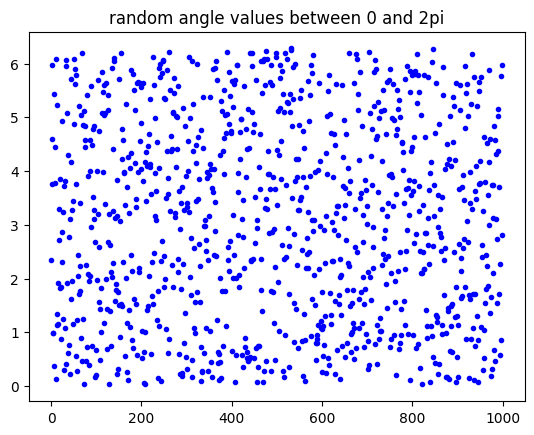

In [8]:
plt.plot(x_values,'b.')
plt.title("random angle values between 0 and 2pi")

Text(0, 0.5, 'sine')

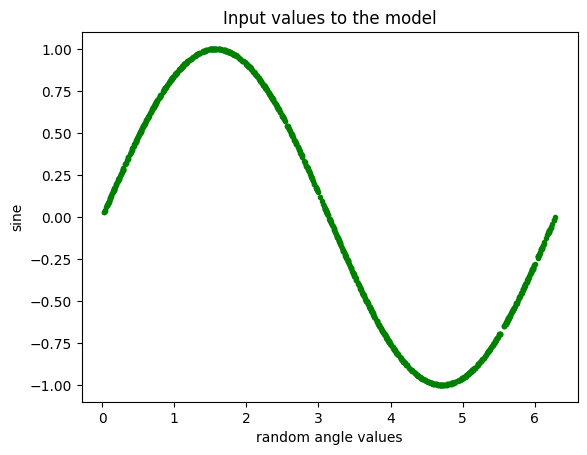

In [9]:
plt.plot(x_values, y_true_values,'g.')
plt.title("Input values to the model")
plt.xlabel("random angle values")
plt.ylabel("sine")

In [10]:
def invoke_tflite_interpreter(input_shape, interpreter, x_value, input_index,
                              output_index):
  input_data = np.reshape(x_value, input_shape)
  interpreter.set_tensor(input_index, input_data)
  interpreter.invoke()
  tflite_output = interpreter.get_tensor(output_index)
  y_quantized = np.reshape(tflite_output, -1)[0]
  return y_quantized



In [11]:
def invoke_tflm_interpreter(input_shape, interpreter, x_value, input_index,
                            output_index):
  input_data = np.reshape(x_value, input_shape)
  interpreter.set_input(input_data, input_index)
  interpreter.invoke()
  y_quantized = np.reshape(interpreter.get_output(output_index), -1)[0]
  return y_quantized

In [12]:
 # Invoke the tflite interpreter with x_values in the range of [0, 2*PI] and
# returns the prediction of the interpreter.
def get_tflite_prediction(model_path, x_values):
  # TFLite interpreter
  tflite_interpreter = tf.lite.Interpreter(
      model_path=model_path,
      experimental_op_resolver_type=tf.lite.experimental.OpResolverType.
      BUILTIN_REF,
  )
  tflite_interpreter.allocate_tensors()

  input_details = tflite_interpreter.get_input_details()[0]
  output_details = tflite_interpreter.get_output_details()[0]
  input_shape = np.array(input_details.get('shape'))

  y_predictions = np.empty(x_values.size, dtype=np.float32)

  for i, x_value in enumerate(x_values):
    y_predictions[i] = invoke_tflite_interpreter(
        input_shape,
        tflite_interpreter,
        x_value,
        input_details['index'],
        output_details['index'],
    )
  return y_predictions


In [14]:
model_path = "models/hello_world_float.tflite"
y_predictions = get_tflite_prediction(model_path, x_values)

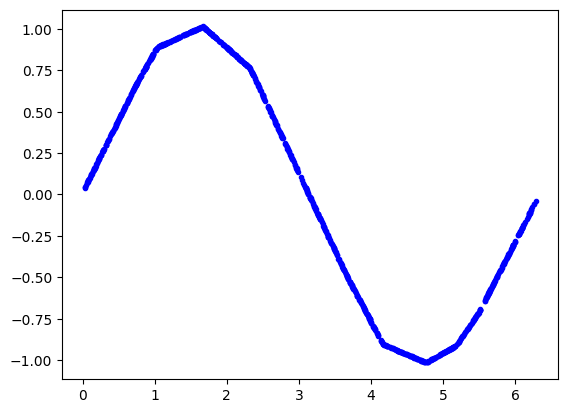

In [15]:
 plt.plot(x_values, y_predictions, 'b.', label='TFLite Prediction')

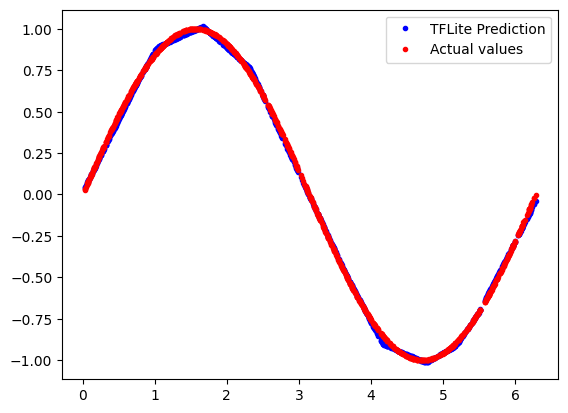

In [16]:
plt.plot(x_values, y_predictions, "b.", label="TFLite Prediction")
plt.plot(x_values, y_true_values, 'r.', label='Actual values')
plt.legend()
plt.show()